# OptSum Collaborative filtering workshop

### 1. What is the data? Triplets & matrix "view" of the data
### 2. Intuition : predict taste using the tastes of similar users/items. KNN algorithm. Advantages & disadvantages
### 3. Introducing latent factor models (aka embeddings)
### 4. Model formulation and optimization
### 5. Training the model, performance and using embeddings

# Lets load the data

### Usual machine learning datasets are of the form:
### $$\it{D} = \{(\mathbf{x}_0, y_0), ..., (\mathbf{x}_N, y_N) \} $$
### Basically a set of input vectors and their associated targets, which we would like to predict.
### However, our dataset is like follows:
### $$\it{D} = \{(u, i, r_{u,i})_0, ..., (u, i, r_{u,i})_N \} $$
### Which is a set of triplets of users, items and ratings which tell us what rating users gave to certain items. These items can be different for all users, so we never had the "full" picture.
### You can visualize this problem with :

<img src="Grid.jpg" height="600" width="600">

### Collaborative filtering can be seen as trying to complete the user-item rating matrix.
### Image of completed ratings
### If we could learn the "hidden" attributes of each user and each item, we could use these as inputs, and complete the matrix as desired. We could even use these attributes to recommend items to users if we think the rating will be high (under the basic assumption we want to see what we like :) ).

### Discussion of parametric models/nonparametric models, KNN

#### Basic code to load MovieLens1M data.
#### One million ratings, from ~3500 users on ~6000 movies

In [15]:
# use sklearn?
import numpy as np
np.random.seed(123)
# One-liner just to load and parse the text file
ratings = np.array([[int(x) for x in r.strip().split('::')] 
                    for r in open("ml-1m/ratings.dat").xreadlines()])[:,:-1]
# Shuffle training examples for fair testing and evaluation
np.random.shuffle(ratings)

n_users, n_items, _ = ratings.max(axis=0) + 1

n = len(ratings)
split_ratios = [0, 0.7, 0.85, 1]
train_ratings, valid_ratings, test_ratings = [ratings[int(n*lo):int(n*up)] for (lo, up) in zip(split_ratios[:-1], split_ratios[1:])]

In [16]:
# sanity check

### How will we find the "hidden" attributes if they are... hidden (also called latent factors) ?

### We will formulate a simple mathematical model, and then apply numerical optimization to find the latent factors of items and users.

### We want our model (function f) to minimize a given error measure between predictions and actual values.

### Most basic error measure is the mean squared error :

## $$ \tilde{r} = f(u, i) $$

## $$ \mathscr{L}(D) = \frac{1}{N} \sum_{i=1...N} (\tilde{r}_i - r_i)  $$

### Our latent factors for users and items are denoted as:

### embedding for user u : 
## $$ p_u $$
### embedding for item i : 
## $$ q_i $$

### And our complicated model will be...

## $$ f(u,i)= q_i^{T} p_u  $$

### Perhaps we can do a little bit better with an even simpler modelling trick: some items are just bad, and some people are always positive. 
### We can model this by simply having a bias term for users and items, along with a main bias term for all ratings.
### This frees latent factors to capture actual attributes of items and users instead of modelling their bias.

### We will have a main bias:

## $$ b $$

### User bias for user u:

## $$ b_u $$

### And item bias for item i:

## $$ b_i $$


### Our final model will simply be the sum of all these terms.

## $$ f(u,i) = b + b_u + b_i + q_i^{T} p_u $$

### We are not quite done yet...

### How do we find biases and embeddings for thousands of users and items?

### There are many numerical optimization algorithms. Lets use one that simple and efficient, gradient descent.

### Given our dataset, we can iteratively move the parameters in the appropriate direction to improve the mean squared error, until we are tired of waiting, or until performance does not improve anymore.

### This simply means moving in the direction of the gradient of the error with regards to the model parameters (usually called $ \theta $),  denoted by:
## $$ \frac{\delta \mathscr{L}}{\delta \theta} $$
### where
## $$ \theta = \{b, b_u, b_i, q_i, p_u\} $$
### for all users $u$ and items $i$.

### The "gradient descent" iteration is:
## $$ \theta \leftarrow \theta + \alpha \frac{\delta \mathscr{L}}{\delta \theta} $$
### Where $\alpha$ controls how big the gradient steps are. We call this the learning rate.

### We could do this on the whole dataset at every iteration, adding the gradients together before updating. This is the standard gradient algorithm (compute the gradient on the whole training set and then update the parameters).
### However we can speed this up alot by using one random training every iteration. Without going into too much detail, the gradient of a random training is, on average, the same as the gradient on the whole training set. This means we can go, in theory, thousands of times faster!

## Now we are ready for the code!

#### Model object class

In [62]:
gradients = ["dL_db", "dL_dbu", "dL_dbv", "dL_dU", "dL_dV"]

class Model(object):
    def __init__(self, latent_factors_size, L2_bias=0, L2_emb=0):
        self.model_parameters = []
        self.gradients = []
        for (name, value) in self.initialize_parameters(latent_factors_size):
            setattr(self, name, value)
            self.gradients.append("dL_d%s" % name)
            self.model_parameters.append(name)
    
    # Used to save parameters during the optimization
    def save_parameters(self):
        return [(name, np.copy(getattr(self, name))) for name in self.model_parameters]
    
    # Used to reload the best parameters once the optimization is finished
    def load_parameters(self, parameters):
        for (name, value) in parameters:
            setattr(self, name, value)
    
    # Random embedding generation from normal distribution, given a size and variance
    def initialize_parameters(self, latent_factors_size=100, std=0.05):
        U = np.random.normal(0, std, size=(n_users + 1, latent_factors_size))
        V = np.random.normal(0, std, size=(n_items + 1, latent_factors_size))
        u = np.zeros(n_users + 1)
        v = np.zeros(n_items + 1)
        return zip(("b", "u", "v", "U", "V"), (0, u, v, U, V))
            
    # Compute the gradients of the biases and embeddings, given 
    def compute_gradient(self, user_ids, item_ids, ratings):
        predicted_ratings = self.predict(user_ids, item_ids)
        residual = ratings - predicted_ratings

        # biases
        dL_db = -2 * residual
        dL_dbu = -2 * residual
        dL_dbv = -2 * residual

        # embeddings
        eu = self.U[user_ids]
        ev = self.V[item_ids]

        dL_dU = -2 * residual * ev
        dL_dV = -2 * residual * eu

        # regularization
        # L2 regularization
        
        
        return dict([(g, eval(g)) for g in gradients])
    
    # Sum of the biases and dot product of the embeddings
    def predict(self, user_ids, item_ids):
        return sum([self.b, 
                    self.u[user_ids], 
                    self.v[item_ids], 
                    (self.U[user_ids] * self.V[item_ids]).sum(axis=-1)])
    
    # Perform a gradient descent step
    def update_parameters(self, user, item, rating, learning_rate = 0.01):
        gradients = self.compute_gradient(user, item, rating)
        self.b = self.b - learning_rate * gradients['dL_db']
        self.u[user] = self.u[user] - learning_rate * gradients['dL_dbu']
        self.v[item] = self.v[item] - learning_rate * gradients['dL_dbv']
        self.U[user] = self.U[user] - learning_rate * gradients['dL_dU']
        self.V[item] = self.V[item] - learning_rate * gradients['dL_dV']

#### Some useful utilitary functions

In [49]:
# Generate a random number 
def sample_random_training_index():
    return np.random.randint(0, len(train_ratings))

# Compute root mean squared error between x and y
def compute_rmse(x, y):
    return ((x - y)**2).mean()**0.5

# utilitary functions for getting the train/valid/test
def get_rmse(ratings):
    return compute_rmse(model.predict(*ratings.T[:2]), ratings.T[2])

def get_trainset_rmse():
    return get_rmse(train_ratings)

def get_validset_rmse():
    return get_rmse(valid_ratings)

def get_testset_rmse():
    return get_rmse(test_ratings)

#### Initialization of the model and optimization

In [68]:
model = Model(latent_factors_size=50)
model.b = train_ratings[:,2].mean()

sgd_iteration_count = 0
best_validation_rmse = 9999
patience = 0
update_frequency = 10000

train_errors = []
valid_errors = []
test_errors = []

best_parameters = None

#### The gradient descent optimization
#### Additional notes concerning optimization:
<ul>
  <li>We will measure performance on the validation set. Optimization will stop when we no longer improve on the validation, after a certain number of iterations (patience).</li>
  <li>We will save the error on the training, validation and test set every 10000 iterations.</li>
  <li>Whenever we see the best validation error up to now, we will save the model parameters.</li>
</ul>

In [69]:
while True:
    try:
        if sgd_iteration_count%update_frequency == 0:
            train_set_rmse = get_trainset_rmse()
            valid_set_rmse = get_validset_rmse()
            test_set_rmse = get_testset_rmse()
            
            train_errors.append(train_set_rmse)
            valid_errors.append(valid_set_rmse)
            test_errors.append(test_set_rmse)
            
            print 'Iteration:      ', sgd_iteration_count
            print 'Validation RMSE:', valid_set_rmse

            if valid_set_rmse < best_validation_rmse:
                print 'Test RMSE      :', test_set_rmse
                print 'Best validation error up to now !'
                patience = 0
                best_validation_rmse = valid_set_rmse
                best_parameters = model.save_parameters()
            else:
                patience += 1
                if patience >= 20:
                    print 'Exceed patience for optimization, stopping!'
                    break
            print
        training_idx = sample_random_training_index()
        user, item, rating = train_ratings[training_idx]
        model.update_parameters(user, item, rating)
        sgd_iteration_count += 1
    except KeyboardInterrupt:
        print 'Stopped Optimization'
        print 'Current valid set performance=%s' % compute_rmse(model.predict(*valid_ratings.T[:2]), valid_ratings[:,2])
        print 'Current test set performance=%s' % compute_rmse(model.predict(*test_ratings.T[:2]), test_ratings[:,2])
        break
        
model.load_parameters(best_parameters)

Iteration:       0
Validation RMSE: 1.11668240606
Test RMSE      : 1.12055471227
Best validation error up to now !

Iteration:       10000
Validation RMSE: 1.07901480825
Test RMSE      : 1.08231718322
Best validation error up to now !

Iteration:       20000
Validation RMSE: 1.04966681676
Test RMSE      : 1.05313427917
Best validation error up to now !

Iteration:       30000
Validation RMSE: 1.04076498859
Test RMSE      : 1.04369430001
Best validation error up to now !

Iteration:       40000
Validation RMSE: 1.01657774279
Test RMSE      : 1.01948532077
Best validation error up to now !

Iteration:       50000
Validation RMSE: 1.00984642716
Test RMSE      : 1.01285915616
Best validation error up to now !

Iteration:       60000
Validation RMSE: 0.997384475382
Test RMSE      : 0.99995920371
Best validation error up to now !

Iteration:       70000
Validation RMSE: 0.98812819828
Test RMSE      : 0.990577323672
Best validation error up to now !

Iteration:       80000
Validation RMSE: 0.

### How much should be wait? How good is the model? Is the optimization ok?

### Lets first try to answer some of these questions by looking at the so-called learning curve

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

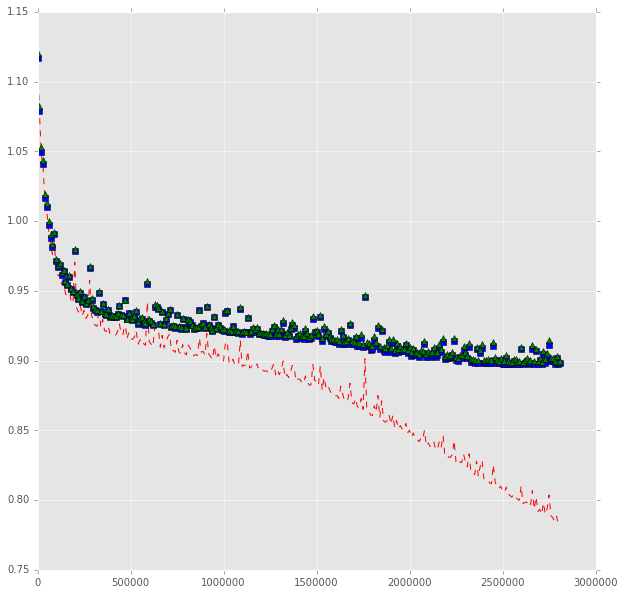

In [83]:
x = update_frequency * np.arange(len(train_errors))
fig = plt.figure(num=None, figsize=(10, 10), dpi=500)
plt.plot(x, train_errors, 'r--', x, valid_errors, 'bs', x, test_errors, 'g^')


### We can see that most of the learning is done early during the optimization. However greater results are achieved by waiting.
### Training error will always be lower than validation and testing error. When the difference is too great we call this "overfitting".
### We can achieve better results by using different latent factor size and different learning rates. You will see that bigger latent factor size will lead to more overfitting. Smaller size will overfit less, but may perform more poorly on the test set. The best is somewhere in between...
### There are also many other things we can do to improve the performance and "generalization":

- regularization
- learning rate reduction
- implicit feedback
- tuning all the hyperparameters of the model

### Now that we have a model, how do we evaluate it, and more importantly, how do we use it?

# TODO
- Embeddings are clusters! Links with unsupervised learning
- Using these for recommendation
- Performance evaluation: ranking and precision

# Merged with product info and fetch most similar movies....

In [91]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)
    s1 = s1.lower()
    s2 = s2.lower()
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

In [92]:
movie_names_lookup = dict([(movies_info[_id][0].split('(')[0].strip().lower(), _id) for _id in movies_info])

In [93]:
len(movie_names_lookup)

3833

In [94]:
name = 'titanic'

def get_closest_name(name):
    name = name.strip().lower()
    ranked = sorted([(n, levenshtein(name, n)) for n in movie_names_lookup], key=lambda x: x[1])
    print 'Closest matches:'
    closest_matches = [(n, movie_names_lookup[n]) for (n, s) in ranked[:10]]
    print closest_matches
    return closest_matches[1][1]

get_closest_name(name)

Closest matches:
[('titanic', 3404), ('picnic', 982), ('tango', 2573), ('trans', 3187), ('piranha', 3024), ('mimic', 1603), ('giant', 948), ('urbania', 3903), ('gothic', 3459), ('titus', 3181)]


982

In [95]:
def compute_cosine_similarity(item):
    numerator = (model.V * model.V[item]).sum(axis=-1)
    denominator = ( (model.V**2).sum(axis=-1)**0.5 * (model.V[item]**2).sum()**0.5)
    return  numerator/denominator 

In [97]:
movie = 1005
print movies_info[movie]

cosine_similarity = compute_cosine_similarity(movie)
closest = cosine_similarity.argsort()[::-1]

# print closest
for c in closest[:15]:
    print 'Score %s --- %s' % (cosine_similarity[c], movies_info[c])
    print 
    
print '###'

for c in closest[-15:]:
    print 'Score %s --- %s' % (cosine_similarity[c], movies_info[c])
    print 


['D3: The Mighty Ducks (1996)', "Children's|Comedy\n"]
Score 1.0 --- ['D3: The Mighty Ducks (1996)', "Children's|Comedy\n"]

Score 0.655260373434 --- ['Home Alone 2: Lost in New York (1992)', "Children's|Comedy\n"]

Score 0.630642661071 --- ['Home Alone (1990)', "Children's|Comedy\n"]

Score 0.60185438823 --- ['Runaway Bride (1999)', 'Comedy|Romance\n']

Score 0.586339650994 --- ['101 Dalmatians (1996)', "Children's|Comedy\n"]

Score 0.563360961702 --- ['American Tail, An (1986)', "Animation|Children's|Comedy\n"]

Score 0.541748782376 --- ['Ghost (1990)', 'Comedy|Romance|Thriller\n']

Score 0.536394799068 --- ['Father of the Bride Part II (1995)', 'Comedy\n']

Score 0.535302315572 --- ['Sister Act (1992)', 'Comedy|Crime\n']

Score 0.534706761054 --- ['Bodyguard, The (1992)', 'Action|Drama|Romance|Thriller\n']

Score 0.522633477726 --- ['Jungle2Jungle (a.k.a. Jungle 2 Jungle) (1997)', "Children's|Comedy\n"]

Score 0.517870320392 --- ['That Darn Cat! (1965)', "Children's|Comedy|Mystery\n

In [88]:
movies_info = open('ml-1m/movies.dat').readlines()

In [89]:
movies_info = dict([(int(m[0]), m[1:]) for m in [m.split('::') for m in movies_info]])

In [ ]:
pca = PCA(n_components=2)
V2d = pca.fit_transform(V)
plt.scatter(*V2d.T)
plt.show()

tsne = TSNE(n_components=2)
V2d = tsne.fit_transform(V)
plt.scatter(*V2d.T)
plt.show()

# Processing the data : basic ratings

# Processing attributes : encoding

# Basic problem formulation : matrix factorization/matrix completion, embeddings, learning representation

In [ ]:
mu = Ratings[:,-1].mean()
bias_u = np.random.normal(0, 0.1, size=N_Users)
bias_v = np.random.normal(0, 0.1, size=N_Movies)
embedding_size = 50
U = np.random.normal(0, 0.1, size=(N_Users, embedding_size))
V = np.random.normal(0, 0.1, size=(N_Movies, embedding_size))
print len(Users), len(Movies)

In [ ]:
def predict(u, v):
    return mu + bias_u[u] + bias_v[v]# + np.dot(U[u], V[v])

In [ ]:
def loss(r, p):
    return ((r-p)**2).mean()

d_L_d_bu = np.zeros(bias_u.shape)
d_L_d_bv = np.zeros(bias_v.shape)

def get_gradient(u, v, r):
    p = predict(u, v)
    d_diff = 2 * (r - p)
    user_bias = bias_u[u]
    item_bias = bias_v[v]
    user_embedding = U[u]
    item_embedding = V[v]
    d_L_d_mu = -d_diff
    d_L_d_bu_tmp = -d_diff * user_bias 
    d_L_d_bv_tmp = -d_diff * item_bias
    
    # reset bias gradients
    d_L_d_bu = np.zeros(bias_u.shape)
    d_L_d_bv = np.zeros(bias_v.shape)
    
    # sum gradients of each user for their bias
    
    # Faster way to do it
    d_L_d_bu_tmp = pd.DataFrame({'u':u, 'g':d_L_d_bu_tmp}).groupby('u').mean().reset_index()
    d_L_d_bv_tmp = pd.DataFrame({'v':v, 'g':d_L_d_bv_tmp}).groupby('v').mean().reset_index()
    
    d_L_d_bu[d_L_d_bu_tmp['u']] = d_L_d_bu_tmp['g']
    d_L_d_bu[d_L_d_bv_tmp['v']] = d_L_d_bv_tmp['g']
    
    
#     for _u in set(u):
#         d_L_d_bu[_u] += d_L_d_bu_tmp[u==_u].sum()
    
#     print 'b'
#     # sum gradients of each item for their bias
#     for _v in set(v):
#         d_L_d_bv[_v] += d_L_d_bv_tmp[v==_v].sum()
    
    return {"mu":d_L_d_mu.mean(), "bu":d_L_d_bu, "bv":d_L_d_bv}

In [ ]:
p = predict(*Ratings.T[:-1])
print loss(Ratings.T[-1], p)
g = get_gradient(*Ratings.T)

lr = 1

mu = mu - lr * g['mu']#.sum()#.mean()
bias_u = bias_u - lr * g['bu']
bias_v = bias_v - lr * g['bv']


### doesnt work!! still

In [ ]:
g['bu']

In [ ]:
bias_v[Ratings.T[1]]

# Adding attributes

# Optimization framework & options

# Regularization

# Optimize!

# Using embeddings

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
x = [float(x.strip()) for x in open('C:/Users/1020384/Desktop/ratio_values.csv').readlines()]
x = np.array(x)

In [ ]:
print x[x>2]
plt.hist(x[x<2], bins=50)

In [ ]:
user_ratings = {}
item_ratings = {}
user_rated_items = {}
item_rating_users = {}

for u, i, r in train_ratings:
    if u not in user_ratings:
        user_ratings[u] = {}
    if i not in item_ratings:
        item_ratings[i] = {}
    user_ratings[u][i] = r
    item_ratings[i][u] = r
    
    if u not in user_rated_items:
        user_rated_items[u] = set()
    if i not in item_rating_users:
        item_rating_users[i] = set()
    user_rated_items[u].add(i)
    item_rating_users[i].add(u)

user, item, rating = valid_ratings[0]

# compute similarity of all other items for that item - itemwise because items are rated by alot of users

similarity = {}
for item_i in (set(item_rating_users.keys()) - set([item])):
    
    i_ratings = item_ratings[item_i]

    # Users that rated both "item" and "i"
    common_users = item_rating_users[item] & item_rating_users[item_i]
    
    # Compute similarity between user and each of the common users.
    current_user_ratings = user_ratings[user]
    
    import pdb; pdb.set_trace()
    
    print common_users